# Used dataset
- Variable: Relative Vorticity, Temperature, U, V
- Period: 2011/02/10 12 UTC - 2011/02/12 12 UTC (6 hourly)
- Domain: 90-180E, 10-70N
- Level:150, 200, 250, 300, 400, 500, 700, 850, 925, 1000 hPa

In [1]:
import warnings
warnings.filterwarnings(action = "ignore")
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from tqdm import tqdm
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid
from matplotlib.ticker import FormatStrFormatter

# 1) Compute the PV at multiple isobaric levels.

In [2]:
def loadERA(variable):
    nc = Dataset("./DATA/%s.nc" % variable, "r")
    
    ncTs    = nc.variables["time"][:].data
    ncTUnit = nc.variables["time"].units
    ncTCal  = nc.variables["time"].calendar
    ncTs    = np.array([ncT.strftime("%Y%m%d%H") for ncT in num2date(ncTs, ncTUnit, calendar = ncTCal)], dtype = str)
    
    ncLevs = nc.variables[    "level"][:].data # hPa
    ncLats = nc.variables[ "latitude"][:].data
    ncLons = nc.variables["longitude"][:].data
    
    data = nc.variables[variable][:].data
    
    return data, ncTs, ncLevs, ncLats, ncLons


def PT():
    p0 = 1000. # hPa
    r_cp = 0.286
    
    temp, ts, levs, lats, lons = loadERA("t") # K
    
    pt = np.full(temp.shape, np.nan, dtype = float)
    
    for i, t in tqdm(enumerate(ts), total = len(ts), desc = "CALC PT:"):
        for j, lev in enumerate(levs):
            for k, lat in enumerate(lats):
                for l, lon in enumerate(lons):
                    pt[i, j, k, l] = temp[i, j, k, l] * (p0 / lev) ** r_cp
    
    return pt # K


def PV():
    g = 9.8
    w = 7.2921 * 10. ** (-5.) # rad/s
    
    vo, ts, levs, lats, lons = loadERA("vo")
    pt                       = PT()
    
    pv = np.full(vo.shape, np.nan, dtype = float)
    
    for i, t in tqdm(enumerate(ts), total = len(ts), desc = "CALC PV:"):
        for j, lev in enumerate(levs):
            for k, lat in enumerate(lats):
                f = 2. * w *np.sin(lat * 2. * np.pi / 360.)
                for l, lon in enumerate(lons):
                    if j == 0:
                        dpt_dp = (pt[i, j + 1, k, l] - pt[i, j    , k, l]) / ((levs[j + 1] - levs[j    ]) * 100.)
                    elif j == len(levs) - 1:
                        dpt_dp = (pt[i, j    , k, l] - pt[i, j - 1, k, l]) / ((levs[j    ] - levs[j - 1]) * 100.)
                    else:
                        dpt_dp = (pt[i, j + 1, k, l] - pt[i, j - 1, k, l]) / ((levs[j + 1] - levs[j - 1]) * 100.) # Centered difference
                    
                    pv[i, j, k, l] = -g * (vo[i, j, k, l] + f) * dpt_dp
    
    return pt, pv, ts, levs, lats, lons

In [10]:
pt, pv, ts, levs, lats, lons = PV()

np.save("./DATA/pt"  , pt  )
np.save("./DATA/pv"  , pv  )
np.save("./DATA/ts"  , ts  )
np.save("./DATA/levs", levs)
np.save("./DATA/lats", lats)
np.save("./DATA/lons", lons)

CALC PV:: 100%|██████████| 12/12 [01:48<00:00,  9.02s/it]


In [3]:
pt   = np.load("./DATA/pt.npy"  )
pv   = np.load("./DATA/pv.npy"  )
ts   = np.load("./DATA/ts.npy"  )
levs = np.load("./DATA/levs.npy")
lats = np.load("./DATA/lats.npy")
lons = np.load("./DATA/lons.npy")

# 2) Make plots for the time evolution of 6-hourly Y-Z cross-sections for PVU, wind speed, and potential temperature across Korean peninsula.

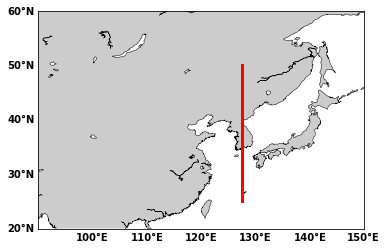

In [4]:
fig, sub = plt.subplots()

m = Basemap(llcrnrlat = 20., urcrnrlat = 60., llcrnrlon = 90., urcrnrlon = 150.,
            resolution = "l", ax = sub)

_ = m.drawcoastlines(linewidth = 0.5)
_ = m.drawmeridians(np.arange(100., 150. + 10., 10.), labels = [0, 0, 0, 1],
                    linewidth = 0)
_ = m.drawparallels(np.arange( 20.,  60. + 10., 10.), labels = [1         ],
                    linewidth = 0)
_ = m.fillcontinents()

lonYZ = 127.5
llatYZ, ulatYZ = 25., 50.

lx, ly = m(lonYZ, llatYZ)
ux, uy = m(lonYZ, ulatYZ)

line = m.plot([lx, ux], [ly, uy], lw = 3, ls = "-", c = "r")

plt.savefig("./FIG/YZregion.png", dpi = 500, bbox_inches = "tight")

In [5]:
def plotYZ(variable):
    fig  = plt.figure(figsize = (15, 10))
    subs = ImageGrid(fig, 111, (3, 4),
                     axes_pad = 0.3, share_all = True, aspect = False,
                     cbar_mode = "single", cbar_location = "right")
    
    ulev = 150.
    
    latIdx = np.where((lats >= llatYZ) & (lats <= ulatYZ))[0]
    lonIdx = np.where(lons == lonYZ)[0]
    levIdx = np.where(levs >= ulev)[0]

    latRegion = lats[latIdx]
    levRegion = levs[levIdx]

    yy, zz = np.meshgrid(latRegion, levRegion)
    
    if variable == "wind":
        ncU, _, _, _, _ = loadERA("u")
        ncV, _, _, _, _ = loadERA("v")
            
        nc = np.power(np.power(ncU, 2) + np.power(ncV, 2), 0.5)
    
    for s, sub in tqdm(enumerate(subs), total = len(subs),
                        desc = variable.upper()):
        _ = sub.set_title("%s/%s/%s %sUTC" % (ts[s][  : 4],
                                              ts[s][4 : 6],
                                              ts[s][6 : 8],
                                              ts[s][8 :  ]))
    
        _ = sub.set_xlim(ulatYZ, llatYZ)
        _ = sub.set_ylim(levRegion.max(), levRegion.min())
        
        _ = sub.set_yscale("log")
        
        _ = sub.set_xticks(np.arange(llatYZ, ulatYZ + 5., 5.))
        _ = sub.set_yticks(np.arange(100., 1000. + 200., 200.))
    
        _ = sub.set_xticklabels(np.arange(llatYZ, ulatYZ + 5., 5.))
        _ = sub.set_yticklabels(np.arange(100., 1000. + 200., 200.))
    
        _ = sub.set_xlabel("Latitude [degree]")
        _ = sub.set_ylabel("Pressure [hPa]")
    
        _ = sub.xaxis.set_major_formatter(FormatStrFormatter("%i"))
        _ = sub.yaxis.set_major_formatter(FormatStrFormatter("%i"))

        if variable == "pvu":
            data = pv[s, :, latIdx, lonIdx].T * 10 ** 6
            data = data[levIdx]
            unit = "PVU"
            cmap = "viridis"
            
            vmin, vmax  = 2., 10.
            levelsContf = np.arange(vmin, vmax + 1., 1.)
            extend      = "max"
            
            contour = sub.contour(yy, zz, data, levels = [1.5], 
                                  colors = "r", linewidths = 2)
            clabel  = sub.clabel(contour, fontsize = 15, fmt = "%.1f")
    
        elif variable == "wind":
            data = nc[s, :, latIdx, lonIdx].T
            data = data[levIdx]
            unit = "Wind speed [m/s]"
            cmap = "jet"
            
            vmin, vmax  = 0., 80.
            levelsContf = np.arange(vmin, vmax + 8., 8.)
            extend      = "max"
        
        elif variable == "pt":
            data = pt[s, :, latIdx, lonIdx].T
            data = data[levIdx]
            unit = "Potential T [K]"
            cmap = "Reds"
            
            vmin, vmax  = 250., 400.
            levelsContf = np.arange(vmin, vmax + 15., 15.)
            extend      = "both"

        contourf = sub.contourf(yy, zz, data, cmap = cmap,
                                vmin = vmin, vmax = vmax, extend = extend,
                                levels = levelsContf)

    cbar = subs.cbar_axes[0].colorbar(contourf,
                                      ticks = levelsContf)
    _ = cbar.ax.set_ylabel(unit)

    plt.savefig("./FIG/%sYZ.png" % variable, dpi = 500, bbox_inches = "tight")

PT: 100%|██████████| 12/12 [00:00<00:00, 85.35it/s]


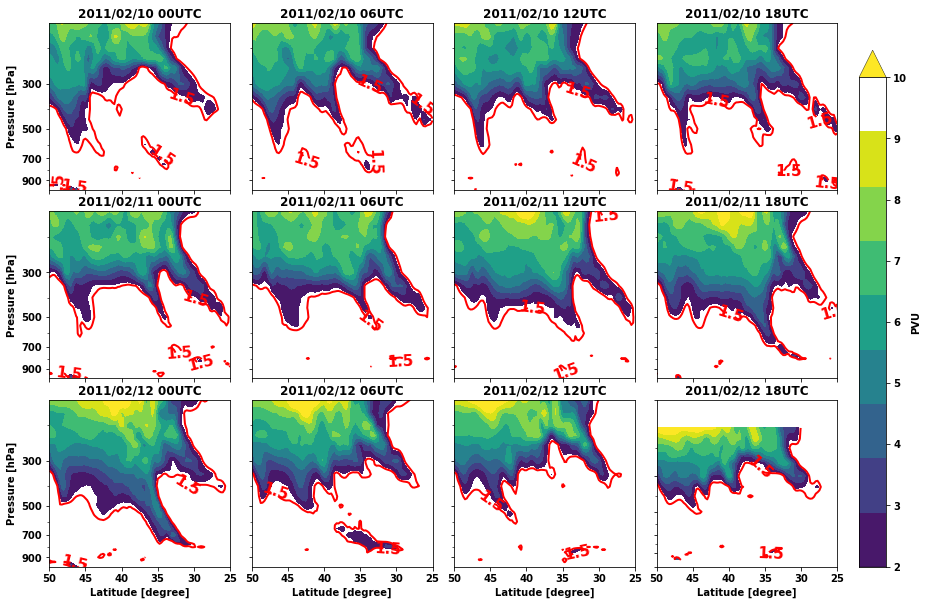

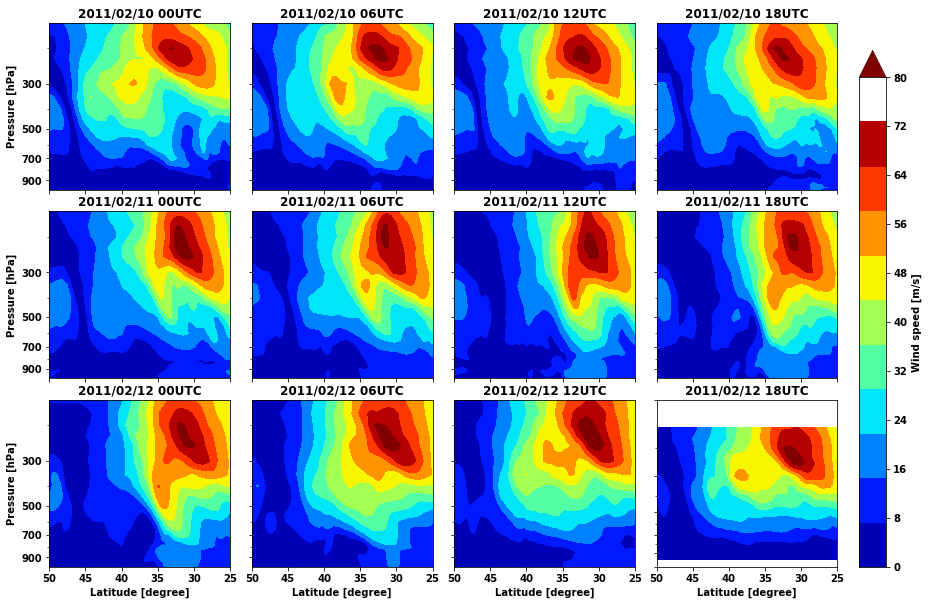

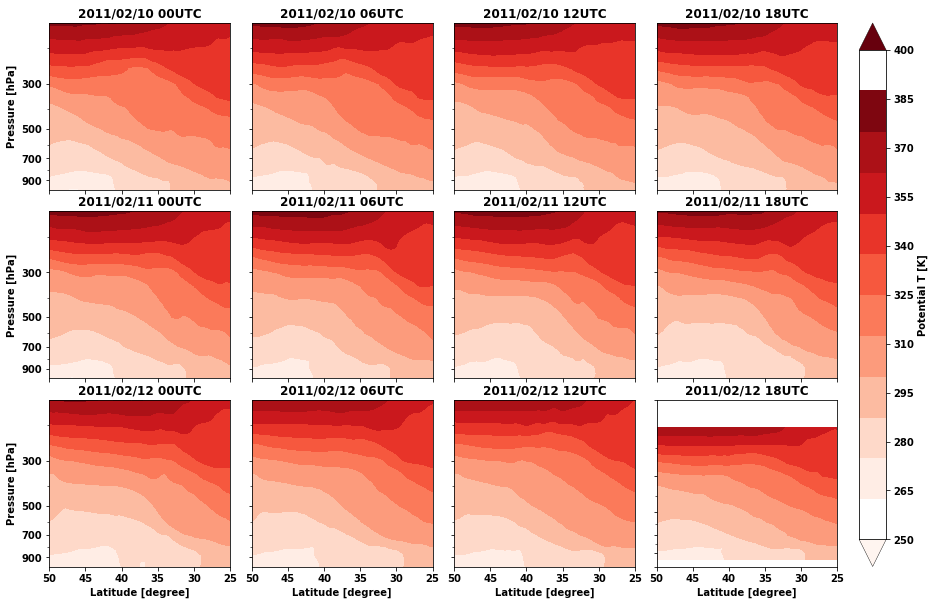

In [158]:
plotYZ("pvu")
plotYZ("wind")
plotYZ("pt")

# 3) Interpolate wind, potential temperature, and pressure on 2 PVU surface.

In [9]:
def loadSurface(variable, pvu):
    if np.isin(variable, ["u", "v"]):
        data, _, _, _, _ = loadERA(variable)
    
    elif np.isin(variable, ["pt"]):
        data = pt
    
    elif np.isin(variable, ["p"]):
        data = levs

    dataSur = np.full((len(ts), len(lats), len(lons)), np.nan, dtype = float)

    for i, t in tqdm(enumerate(ts), total = len(ts),
                     desc = "INTERPOLATE %s" % variable.upper()):
        for k, lat in enumerate(lats):
            for l, lon in enumerate(lons):
                pvLevs   =   pv[i, :, k, l] * 10 ** 6
                
                if np.isin(variable, ["u", "v", "pt"]):
                    dataLevs = data[i, :, k, l]
                
                elif np.isin(variable, ["p"]):
                    dataLevs = data
                
                for j in range(len(pvLevs))[: -1]:
                    if (pvLevs[j] >= pvu) & (pvLevs[j + 1] <= pvu):
                        dataSur[i, k, l] = dataLevs[j] + (pvu - pvLevs[j]) * (dataLevs[j + 1] - dataLevs[j]) /(pvLevs[j + 1] - pvLevs[j])
                        break
                        
                    elif (pvLevs[j] <= pvu) & (pvLevs[j + 1] >= pvu):
                        dataSur[i, k, l] = dataLevs[j] + (pvu - pvLevs[j]) * (dataLevs[j + 1] - dataLevs[j]) /(pvLevs[j + 1] - pvLevs[j])
                        break
                        
                    else:
                        continue
    
    return dataSur

In [12]:
windU = loadSurface("u", 2.)
windV = loadSurface("v", 2.)
temp  = loadSurface("pt", 2.)
pres  = loadSurface("p", 2.)

INTERPOLATE P: 100%|██████████| 12/12 [00:47<00:00,  3.92s/it]


# 4) Make plots for potential temperature (shading) and pressure (shading) with horizontal wind vectors at 2 PVU surface.

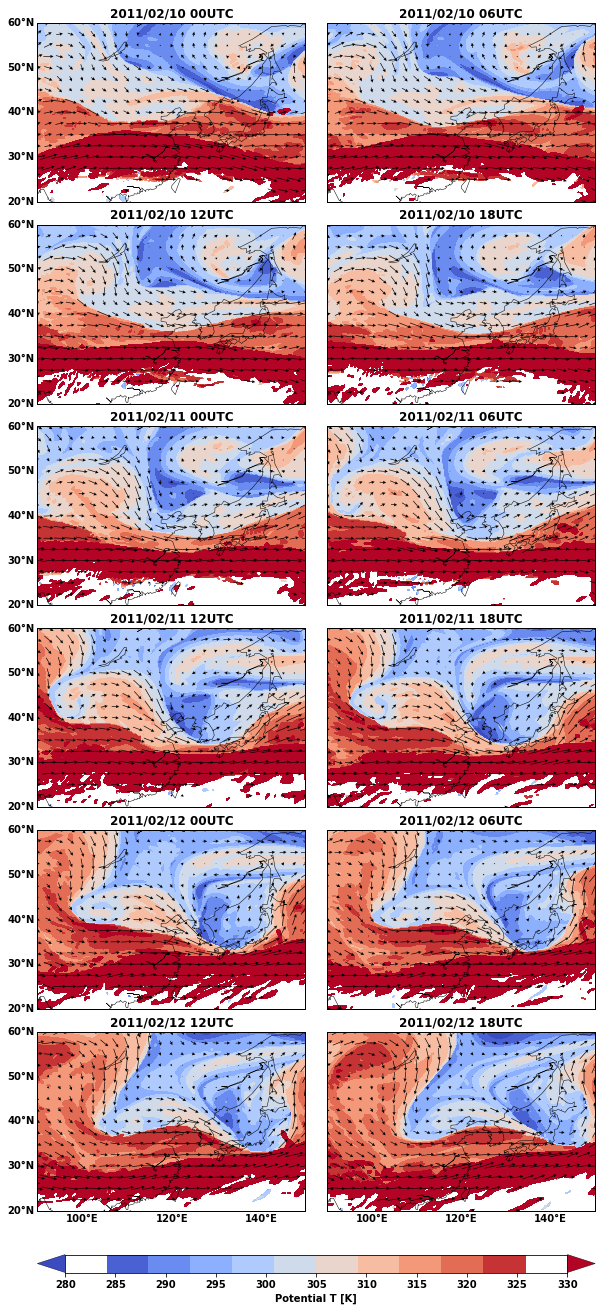

In [20]:
xx, yy = np.meshgrid(lons, lats)

fig  = plt.figure(figsize = (10, 23))
subs = ImageGrid(fig, 111, (6, 2),
                 axes_pad = 0.3, share_all = True, aspect = False,
                 cbar_mode = "single", cbar_location = "bottom")

for s, sub in enumerate(subs):
    _ = sub.set_title("%s/%s/%s %sUTC" % (ts[s][  : 4],
                                          ts[s][4 : 6],
                                          ts[s][6 : 8],
                                          ts[s][8 :  ]))
    
    m = Basemap(llcrnrlat = 20., urcrnrlat = 60.,
                llcrnrlon = 90., urcrnrlon = 150.,
                resolution = "c", ax = sub)
    
    _ = m.drawmapboundary(fill_color = "None", zorder = 9)
    _ = m.drawcoastlines(linewidth = 0.5, zorder = 5)
    
    if np.isin(s, [10, 11]):
        _ = m.drawmeridians(np.arange(100., 150. + 20., 20.),
                            labels = [0, 0, 0, 1], linewidth = 0)
    if np.isin(s, [0, 2, 4, 6, 8, 10]):
        _ = m.drawparallels(np.arange( 20.,  60. + 10., 10.),
                            labels = [1         ], linewidth = 0)
    
    x, y = m(xx, yy)
    
    inter = 10 # * 0.25 degree
    
    quiver = m.quiver(x[:: inter, :: inter], y[:: inter, :: inter],
                      windU[s, :: inter, :: inter], windV[s, :: inter, :: inter],
                      units = "xy", pivot = "mid", headwidth = 5,
                      scale = 15, scale_units = "xy", zorder = 7)
    
    vmin, vmax  = 280., 330.
    levelsContf = np.arange(vmin, vmax + 5., 5.)
    unit        = "Potential T [K]"
            
    plot = m.contourf(x, y, temp[s], levels = levelsContf, extend = "both",
                      cmap = "coolwarm", vmin = vmin, vmax = vmax, zorder = 3)
    
cbar = subs.cbar_axes[0].colorbar(plot, ticks = levelsContf)
_    = cbar.ax.set_xlabel(unit)

plt.savefig("./FIG/2pvu_pt.png", dpi = 500, bbox_inches = "tight")

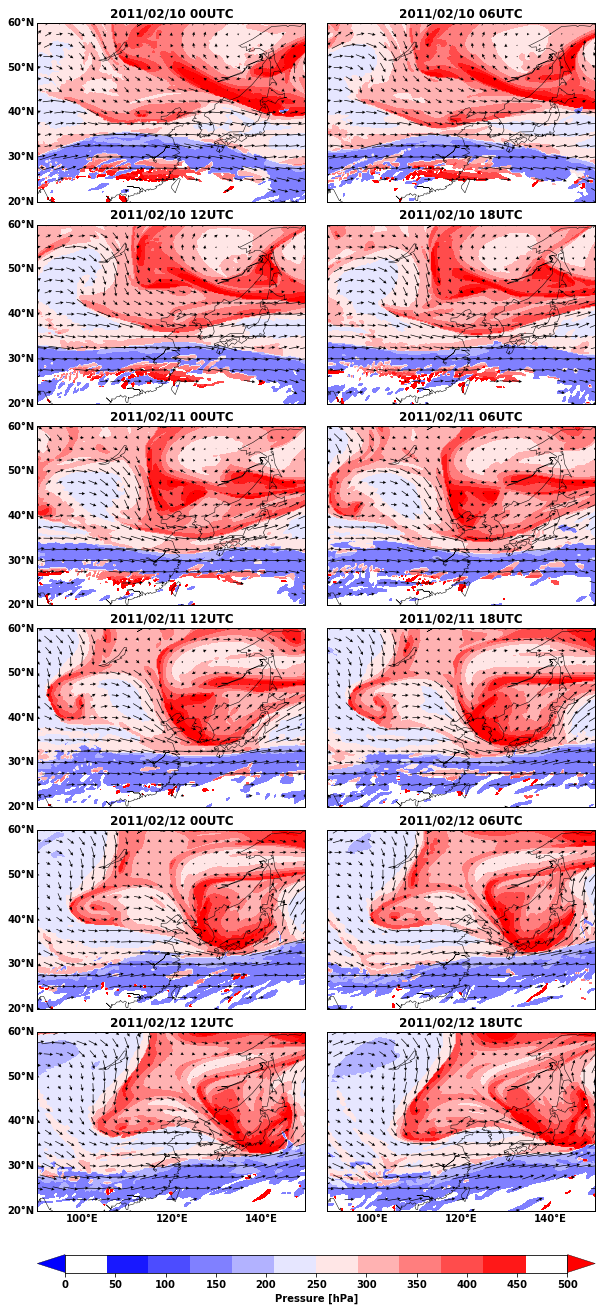

In [74]:
fig  = plt.figure(figsize = (10, 23))
subs = ImageGrid(fig, 111, (6, 2),
                 axes_pad = 0.3, share_all = True, aspect = False,
                 cbar_mode = "single", cbar_location = "bottom")

for s, sub in enumerate(subs):
    _ = sub.set_title("%s/%s/%s %sUTC" % (ts[s][  : 4],
                                          ts[s][4 : 6],
                                          ts[s][6 : 8],
                                          ts[s][8 :  ]))
    
    m = Basemap(llcrnrlat = 20., urcrnrlat = 60.,
                llcrnrlon = 90., urcrnrlon = 150.,
                resolution = "c", ax = sub)
    
    _ = m.drawmapboundary(fill_color = "None", zorder = 9)
    _ = m.drawcoastlines(linewidth = 0.5, zorder = 5)
    
    if np.isin(s, [10, 11]):
        _ = m.drawmeridians(np.arange(100., 150. + 20., 20.),
                            labels = [0, 0, 0, 1], linewidth = 0)
    if np.isin(s, [0, 2, 4, 6, 8, 10]):
        _ = m.drawparallels(np.arange( 20.,  60. + 10., 10.),
                            labels = [1         ], linewidth = 0)
    
    x, y = m(xx, yy)
    
    inter = 10 # * 0.25 degree
    
    quiver = m.quiver(x[:: inter, :: inter], y[:: inter, :: inter],
                      windU[s, :: inter, :: inter], windV[s, :: inter, :: inter],
                      units = "xy", pivot = "mid", headwidth = 5,
                      scale = 15, scale_units = "xy", zorder = 7)
    
    vmin, vmax  = 0., 500.
    levelsContf = np.arange(vmin, vmax + 50., 50.)
    unit        = "Pressure [hPa]"
            
    plot = m.contourf(x, y, pres[s], extend = "both", levels = levelsContf,
                      cmap = "bwr", vmin = vmin, vmax = vmax, zorder = 3)
    
cbar = subs.cbar_axes[0].colorbar(plot, ticks = levelsContf)
_    = cbar.ax.set_xlabel(unit)

plt.savefig("./FIG/2pvu_pres.png", dpi = 500, bbox_inches = "tight")